In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO
import missingno as msno
from sklearn.impute import SimpleImputer

from patsy import demo_data
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer

import scipy as sp
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

from sklearn.datasets import load_boston

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')

warnings.filterwarnings("ignore")

# 1. 데이터 전처리 기초

# 1. 결측값

## 1.1 결측값 확인

In [3]:
csv_data = StringIO("""
x1,x2,x3,x4,x5
1,0.1,"1",2019-01-01,A
2,,,2019-01-02,B
3,,"3",2019-01-03,C
,0.4,"4",2019-01-04,A
5,0.5,"5",2019-01-05,B
,,,2019-01-06,C
7,0.7,"7",,A
8,0.8,"8",2019-01-08,B
9,0.9,,2019-01-09,C
""")

df = pd.read_csv(csv_data, dtype={"x1": pd.Int64Dtype()}, parse_dates=[3])
df

,x1,x2,x3,x4,x5
0,1,0.1,1.0,2019-01-01,A
1,2,NaN,NaN,2019-01-02,B
2,3,NaN,3.0,2019-01-03,C
3,<NA>,0.4,4.0,2019-01-04,A
4,5,0.5,5.0,2019-01-05,B
5,<NA>,NaN,NaN,2019-01-06,C
6,7,0.7,7.0,NaT,A
7,8,0.8,8.0,2019-01-08,B
8,9,0.9,NaN,2019-01-09,C


- 결측값이 있는 임시 데이터를 생성하였다.


- 실제 데이터를 불러올때도 정수형, 날짜형 등 자료형태를 명시하는 것이 중요하다.


- 날짜형은 자료형태를 지정하지 않으면 object로 불러와 dt 인자를 적용할 수 없다.

In [4]:
df.isnull().sum()

x1    2
x2    3
x3    3
x4    1
x5    0
dtype: int64

- `isnull().sum()` 을 이용해 각 열마다 결측값의 개수를 확인 가능하다.

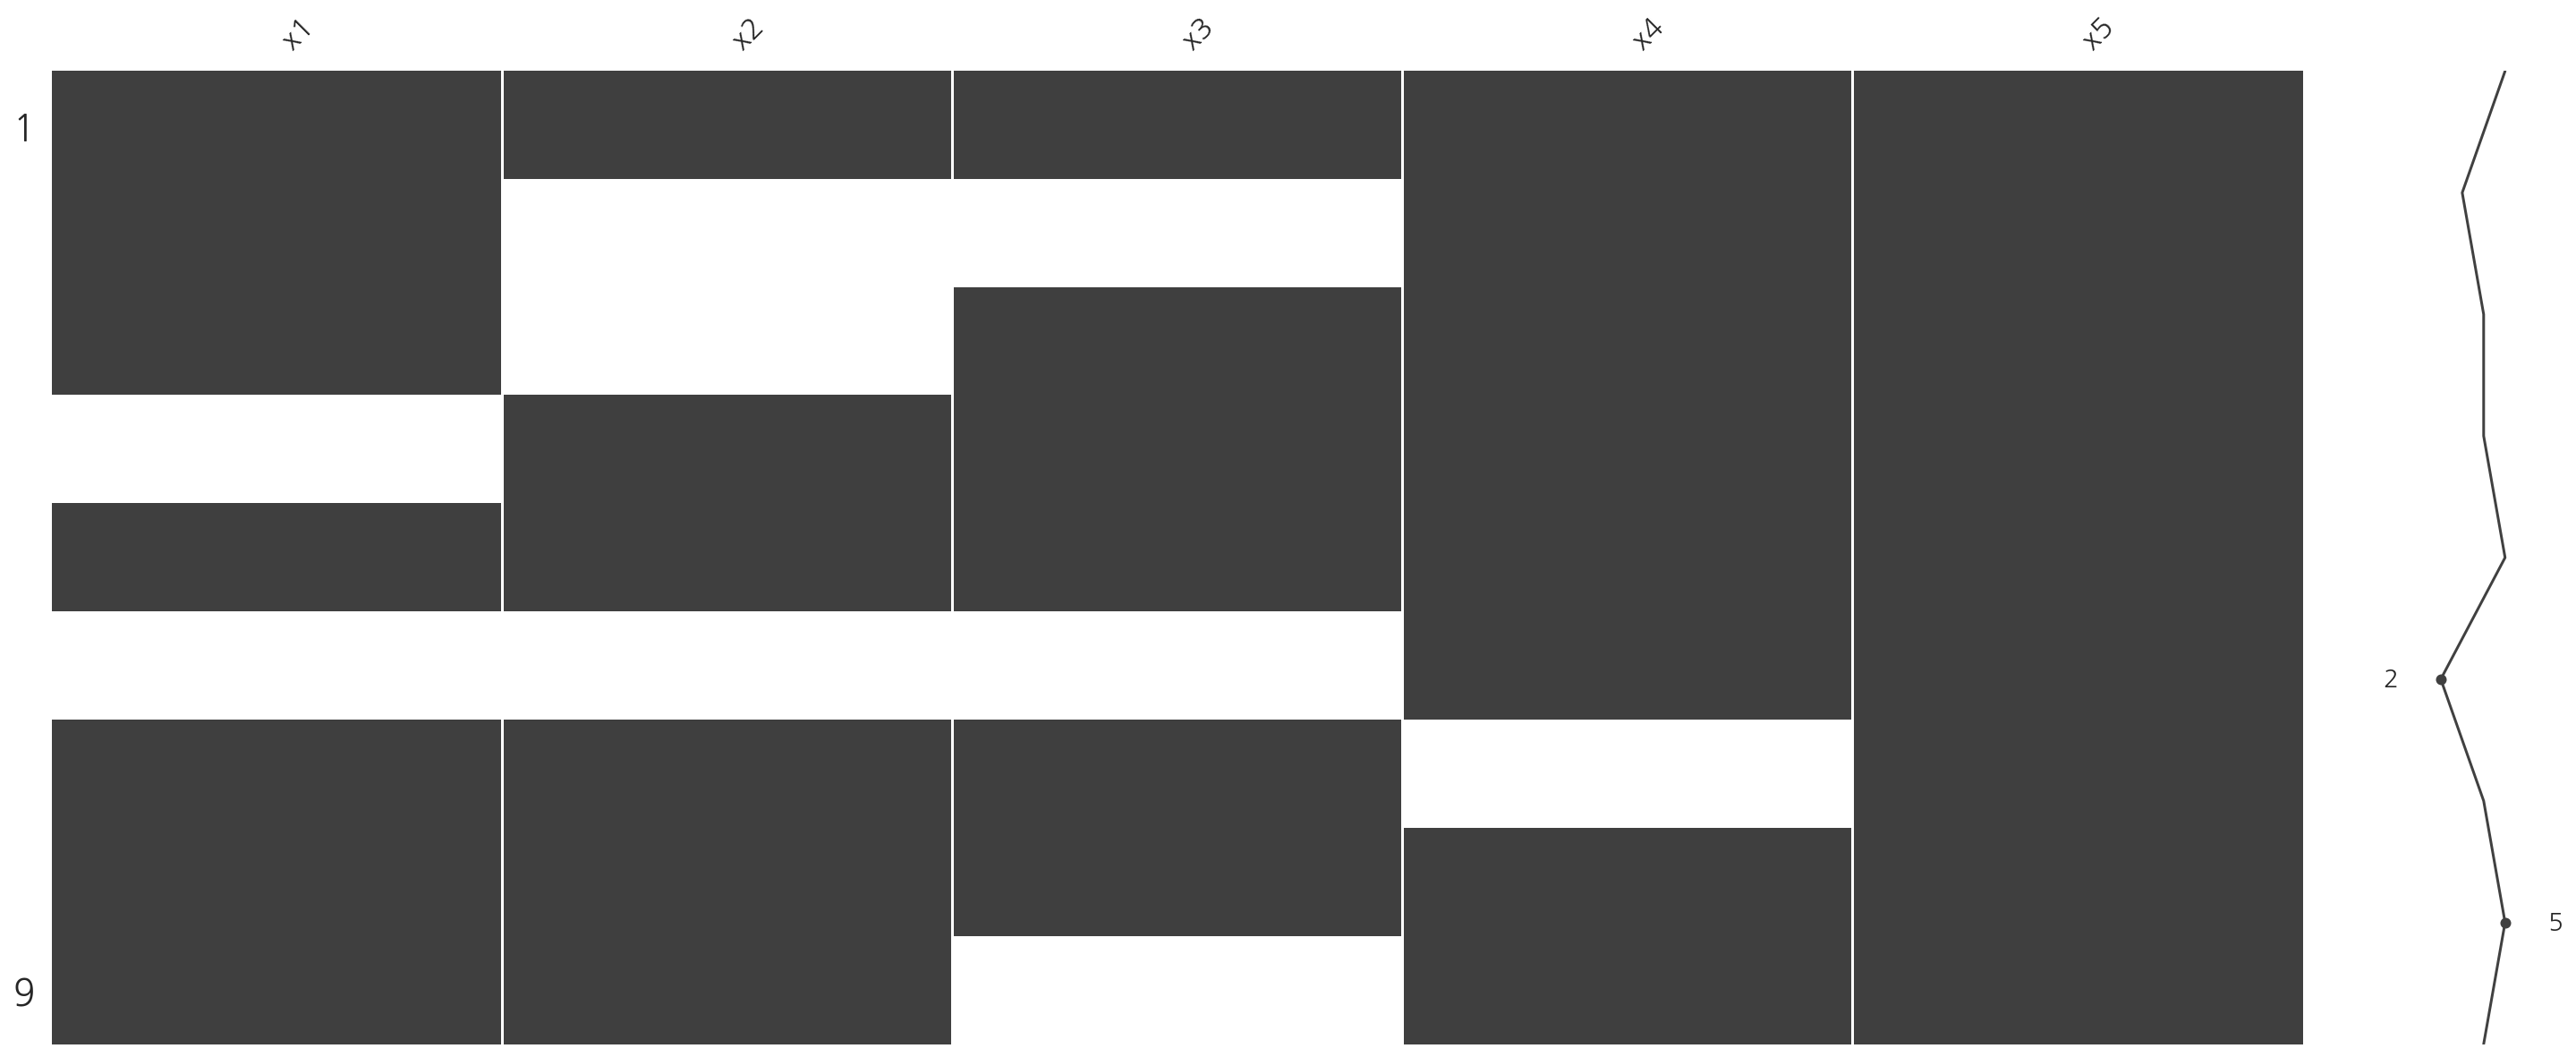

In [5]:
msno.matrix(df)
plt.show()

- `msno.matrix()` 를 이용해 결측 데이터 시각화가 가능하다.


- 결측 데이터는 흰색, 결측이 아니면 검은색으로 나타난다.

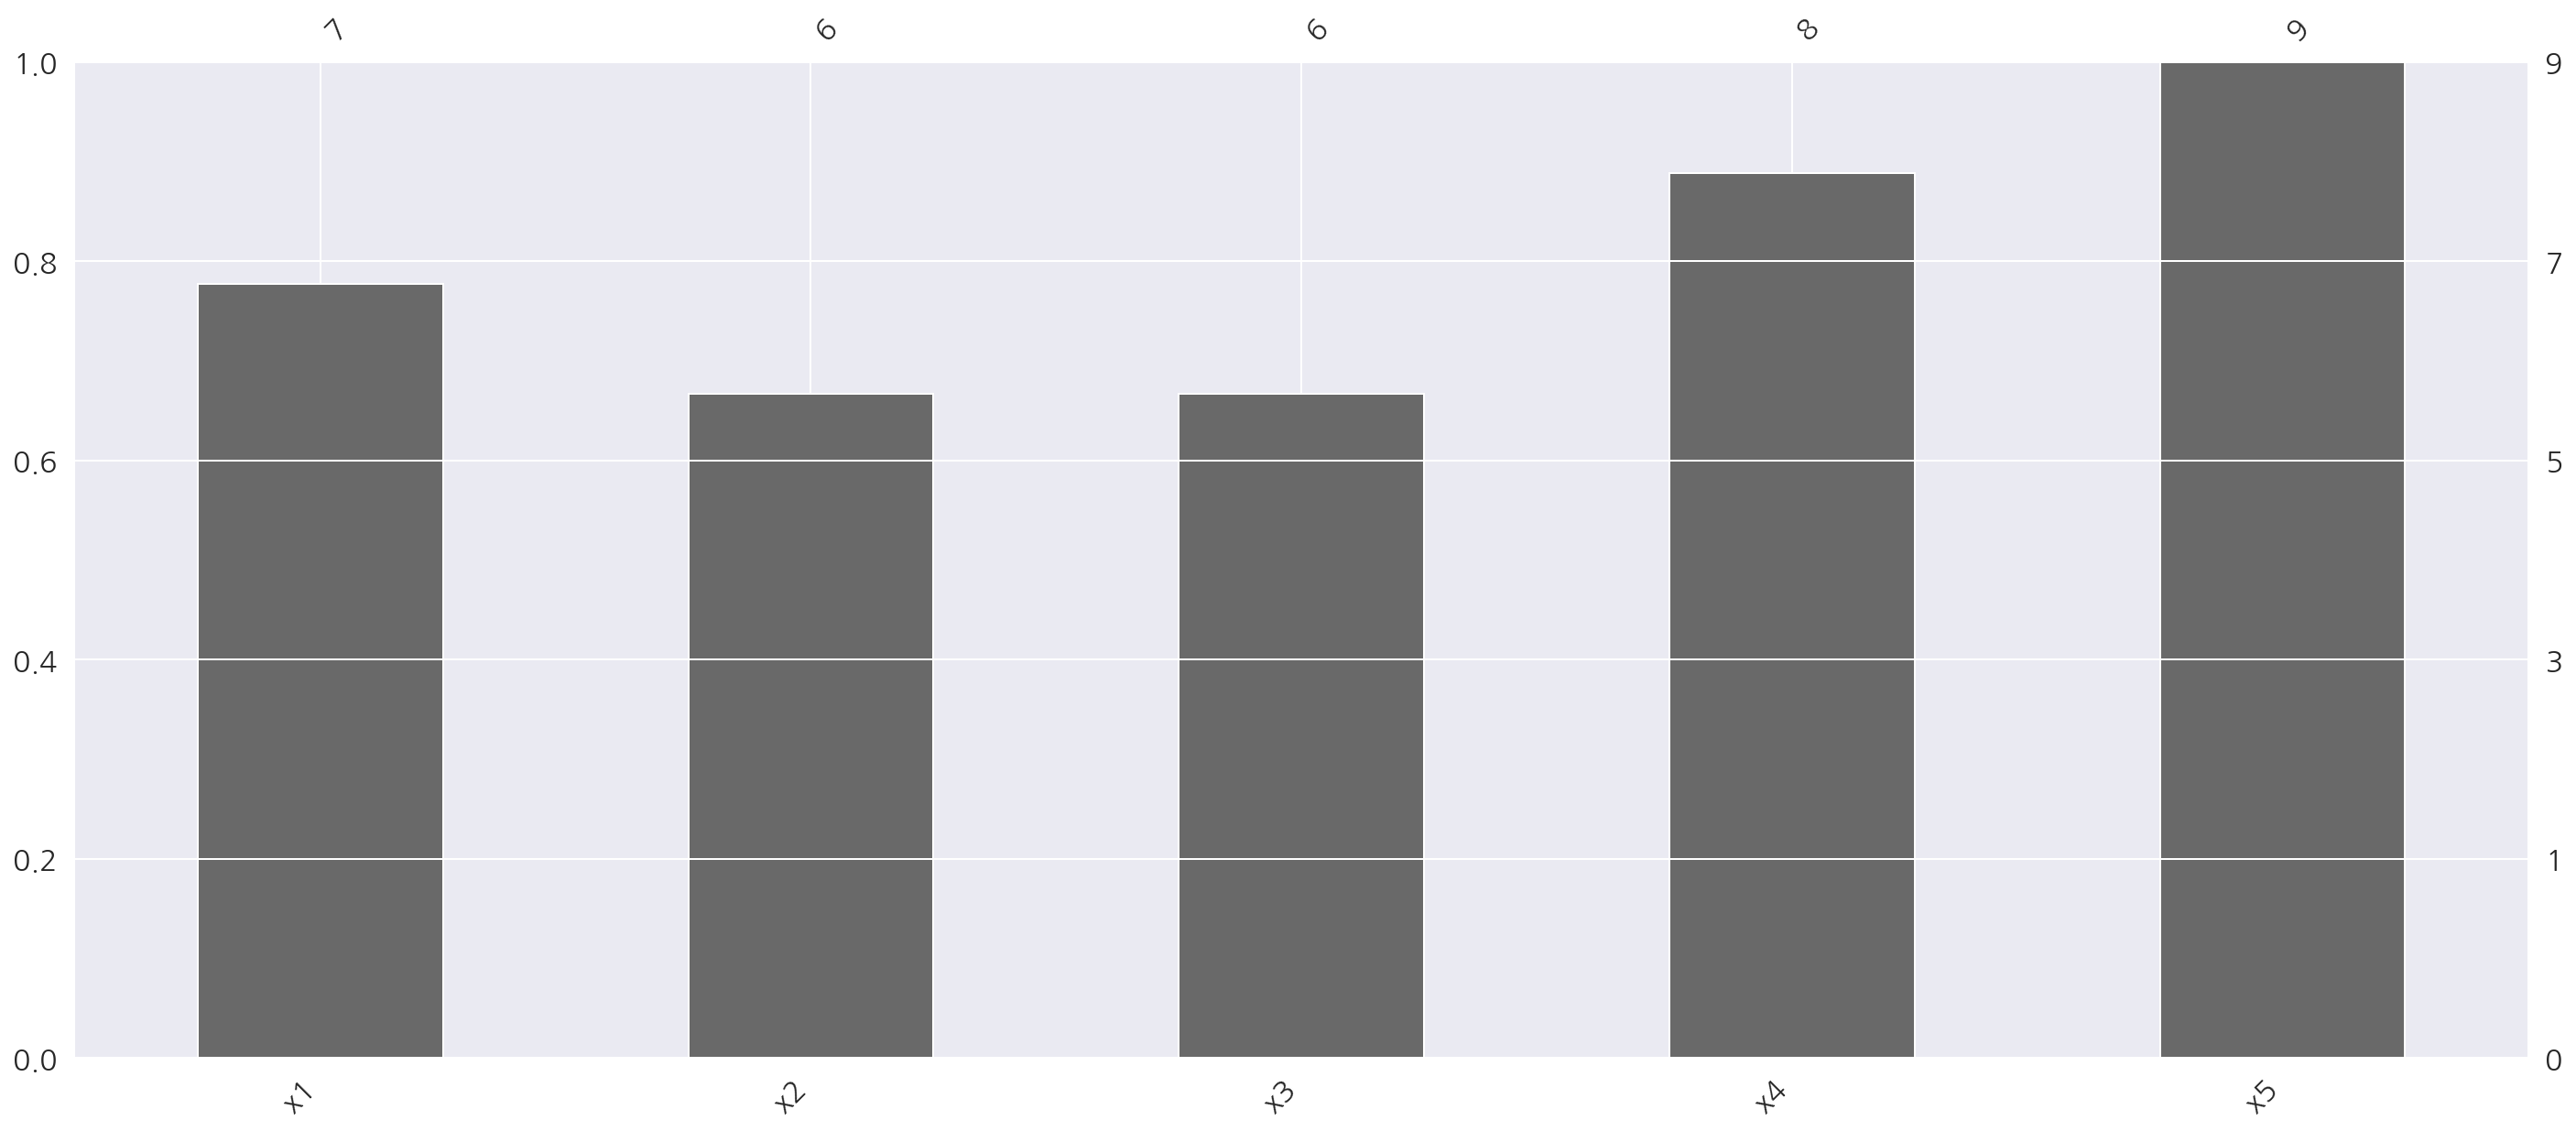

In [6]:
msno.bar(df)
plt.show()

- `msno.bar()` 를 이용해 비결측 데이터의 갯수 시각화가 가능하다.

## 1.2 결측값 처리

### 1.2.1 결측값 삭제

In [7]:
df.dropna()

,x1,x2,x3,x4,x5
0,1,0.1,1.0,2019-01-01,A
4,5,0.5,5.0,2019-01-05,B
7,8,0.8,8.0,2019-01-08,B


- `dropna()` 를 이용해 결측값이 있는 행을 제거 가능하다.

In [8]:
df.dropna(axis=1)

,x5
0,A
1,B
2,C
3,A
4,B
5,C
6,A
7,B
8,C


- `axis=1` 옵션을 이용해 결측값이 있는 열을 제거 가능하다.

In [9]:
df.dropna(thresh=7, axis=1)

,x1,x4,x5
0,1,2019-01-01,A
1,2,2019-01-02,B
2,3,2019-01-03,C
3,<NA>,2019-01-04,A
4,5,2019-01-05,B
5,<NA>,2019-01-06,C
6,7,NaT,A
7,8,2019-01-08,B
8,9,2019-01-09,C


- `thresh=N` 과 `axis` 옵션을이용해 N개 이상 비결측 데이터가 있는 행 또는 열만 남길수 있다.

### 1.2.2 결측값 대체

In [10]:
# 평균값, 중앙값, 최빈값으로 대체
df.fillna({"x1":df.x1.mean(), 
           "x2":df.x2.median(), 
           "x3":df.x3.value_counts().sort_values(ascending=False).index[0]}
         )



,x1,x2,x3,x4,x5
0,1,0.1,1.0,2019-01-01,A
1,2,0.6,1.0,2019-01-02,B
2,3,0.6,3.0,2019-01-03,C
3,5,0.4,4.0,2019-01-04,A
4,5,0.5,5.0,2019-01-05,B
5,5,0.6,1.0,2019-01-06,C
6,7,0.7,7.0,NaT,A
7,8,0.8,8.0,2019-01-08,B
8,9,0.9,1.0,2019-01-09,C


- `fillna()` 를 이용해서 각 변수별로 대체값을 지정 가능하다.

In [11]:
# 최빈값으로 수정
imp = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")

col = ["x1","x2","x3"]
df[col] = imp.fit_transform(df[col])
df

,x1,x2,x3,x4,x5
0,1.0,0.1,1.0,2019-01-01,A
1,2.0,0.1,1.0,2019-01-02,B
2,3.0,0.1,3.0,2019-01-03,C
3,1.0,0.4,4.0,2019-01-04,A
4,5.0,0.5,5.0,2019-01-05,B
5,1.0,0.1,1.0,2019-01-06,C
6,7.0,0.7,7.0,NaT,A
7,8.0,0.8,8.0,2019-01-08,B
8,9.0,0.9,1.0,2019-01-09,C


- `sklearn` 의 `SimpleImputer` 를 사용하여 결측값에 대체가 가능하다.


- `strategy` 옵션으로 평균, 중앙값, 최빈값, 상수값 등을 사용가능하다.
```python
SimpleImputer(strategy = 'mean')
SimpleImputer(strategy = 'median')
SimpleImputer(strategy = 'most_frequent')
SimpleImputer(strategy = 'constant', fill_value=1)
```

## 1.3 타이타닉 예제

In [12]:
# titanic 데이터 불러오기
titanic = sns.load_dataset("titanic")
titanic.tail()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
886,0,2,male,27.0,0,0,13.00,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.00,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.45,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.00,C,First,man,True,C,Cherbourg,yes,True
890,0,3,male,32.0,0,0,7.75,Q,Third,man,True,NaN,Queenstown,no,True


**결측값 확인**

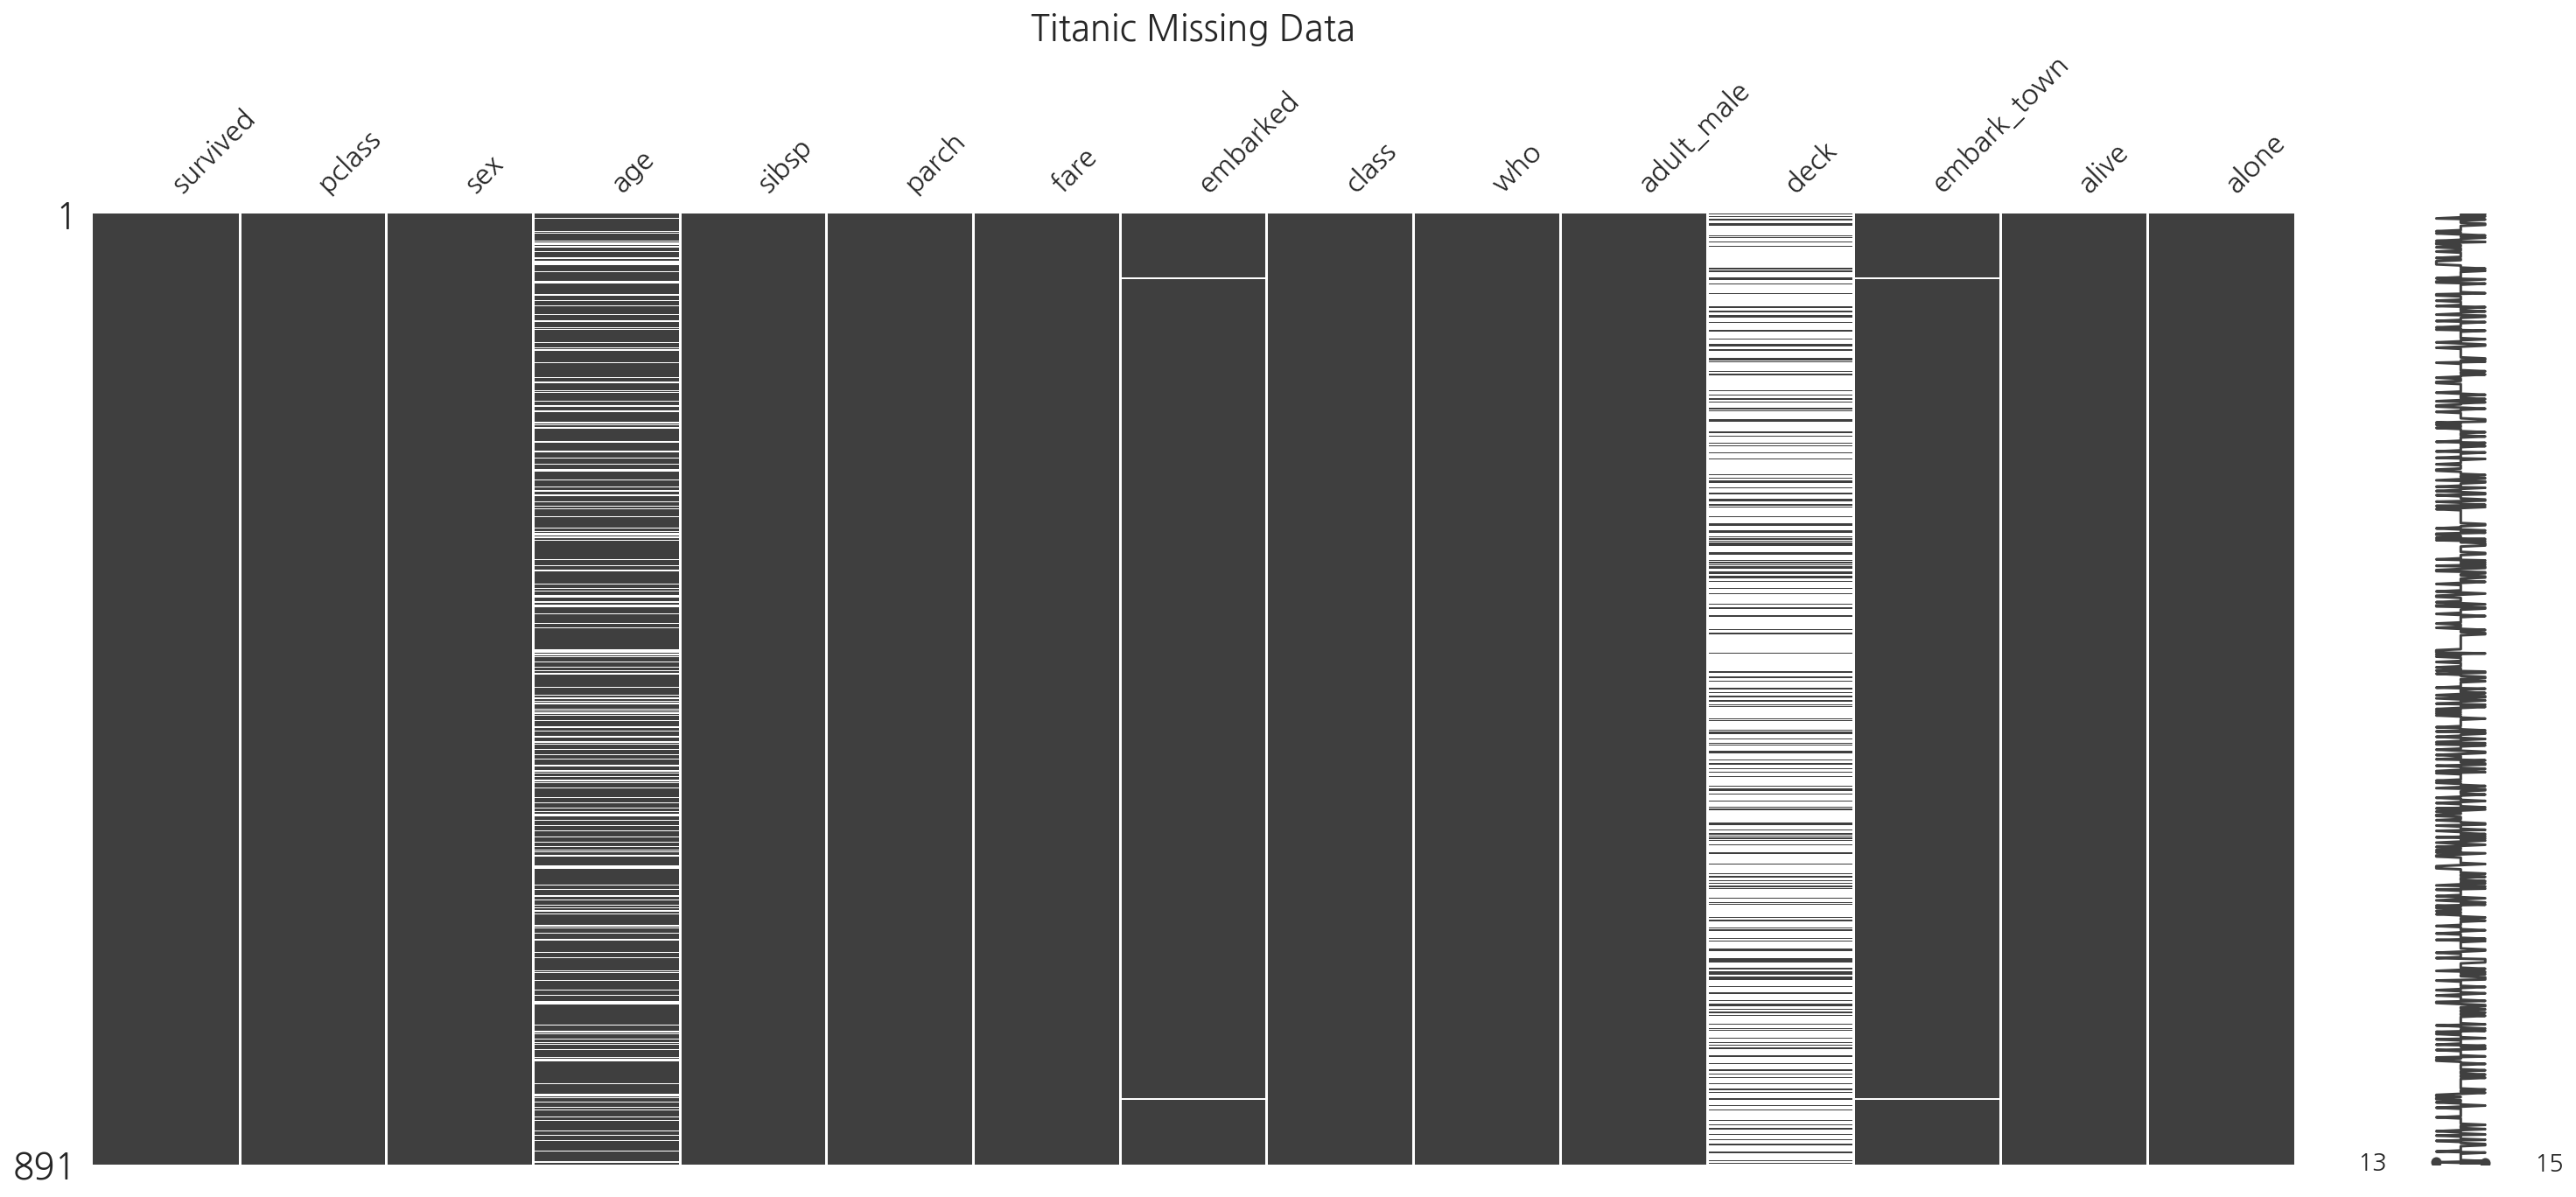

In [13]:
msno.matrix(titanic)
plt.title("Titanic Missing Data", fontsize = 20)
plt.show()

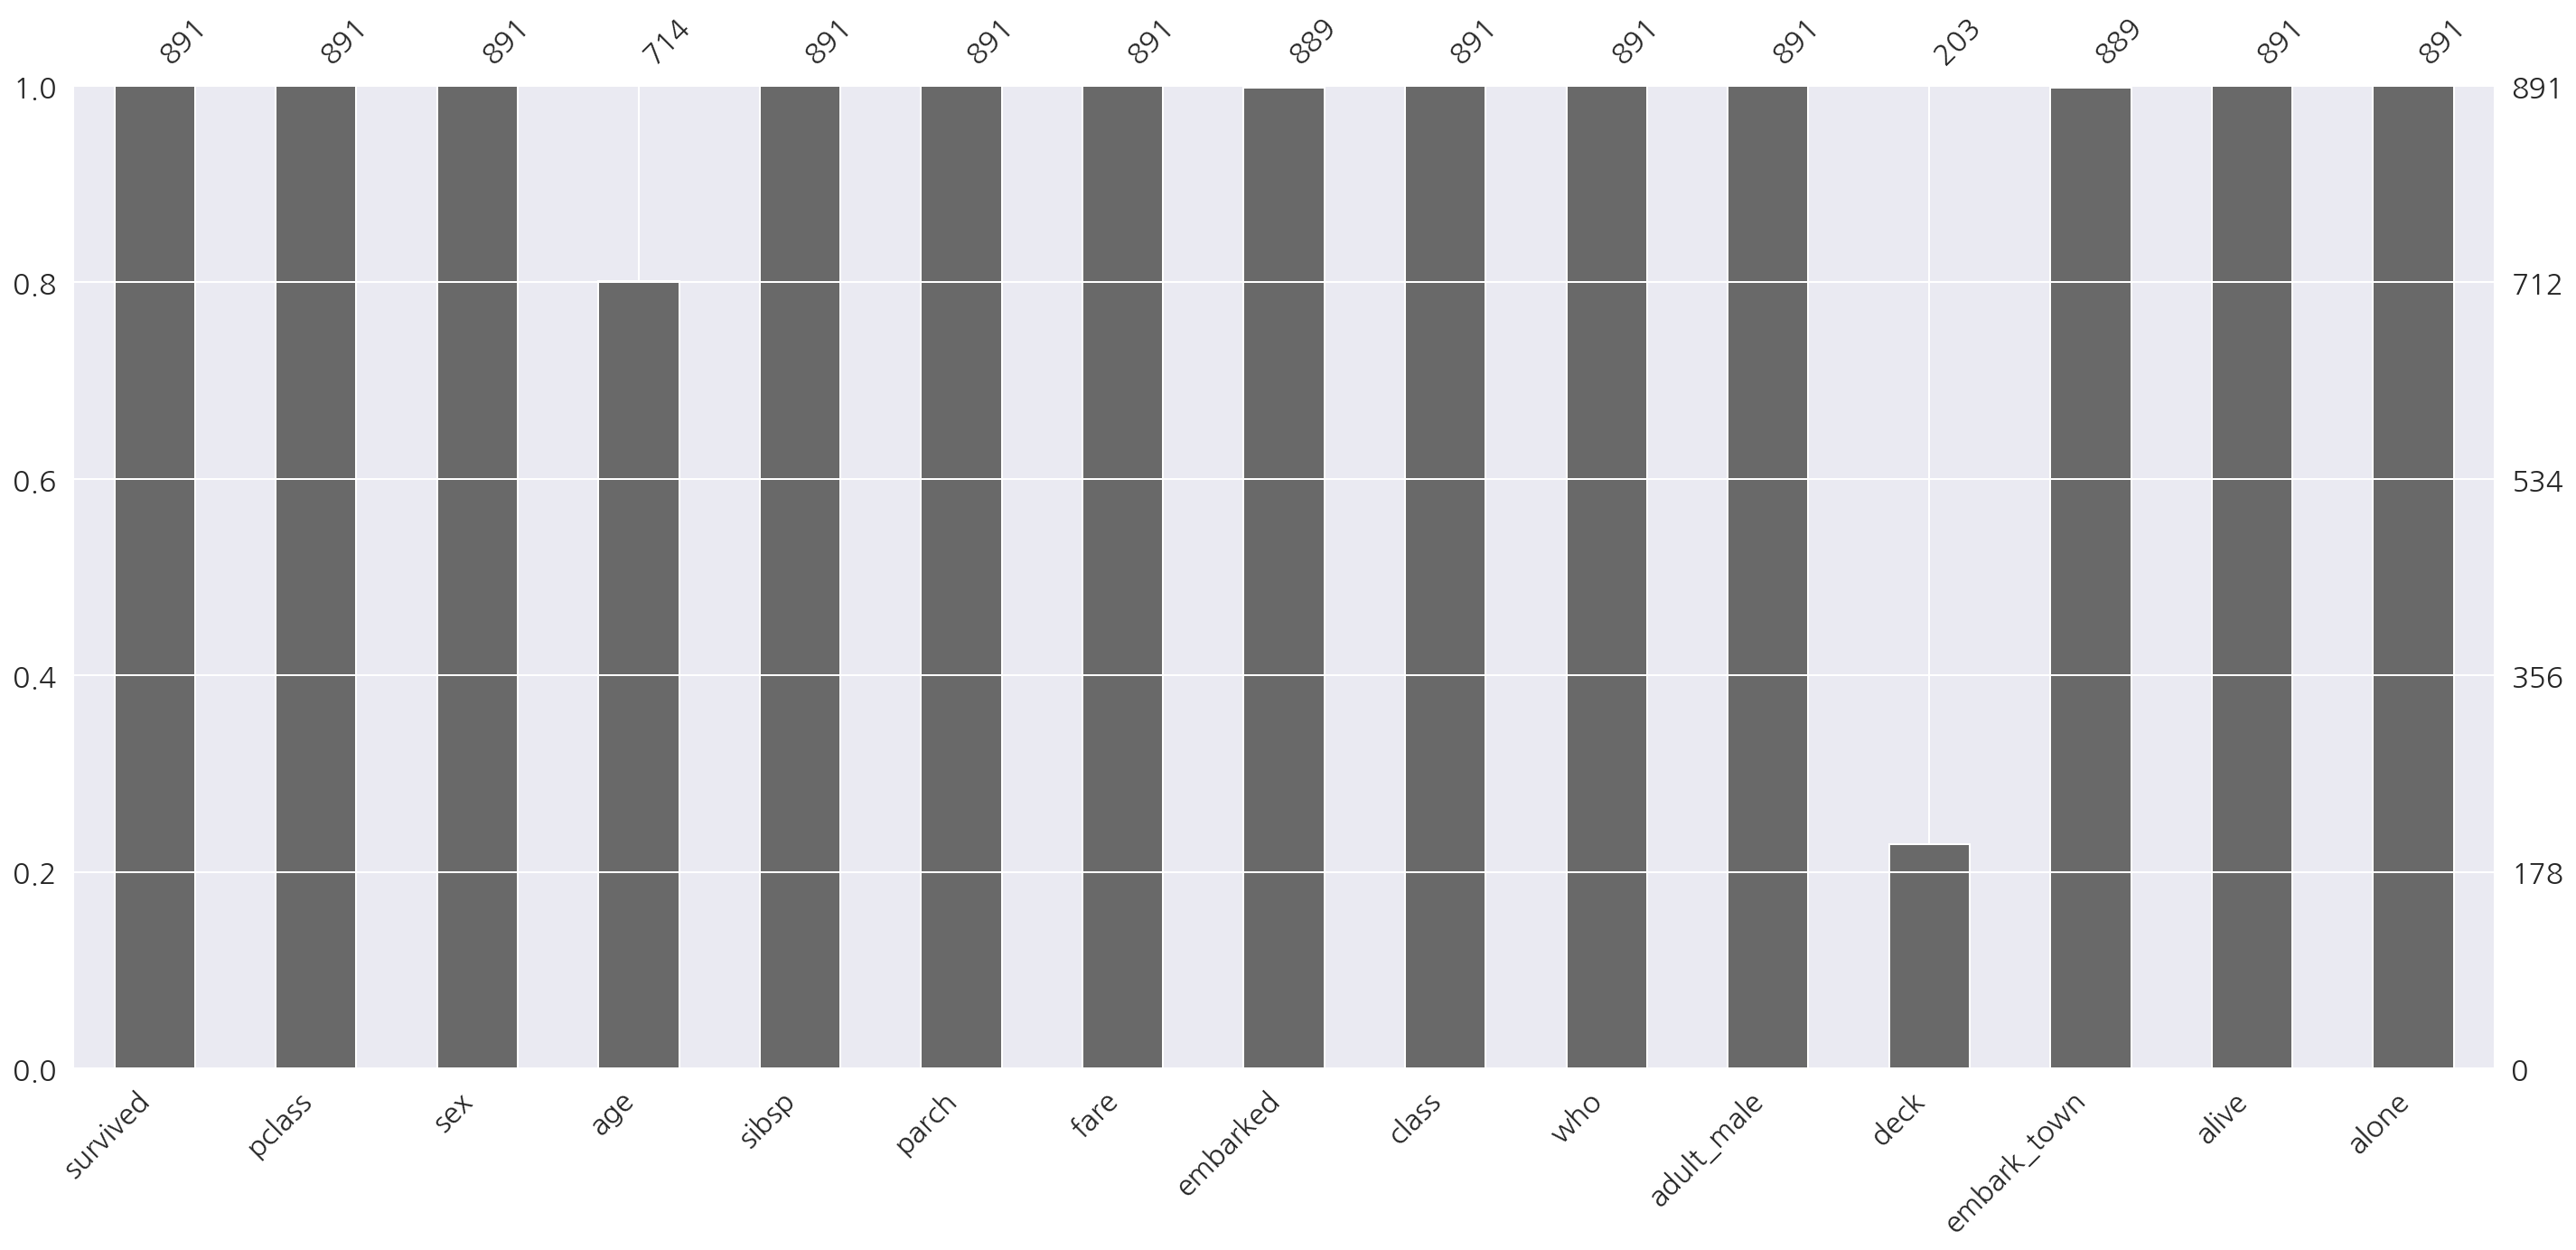

In [14]:
msno.bar(titanic)
plt.show()

- titanic 데이터의 경우 age, embarked, deck, embarked_town에 결측값이 존재함을 알 수 있다.

**결측값 삭제**

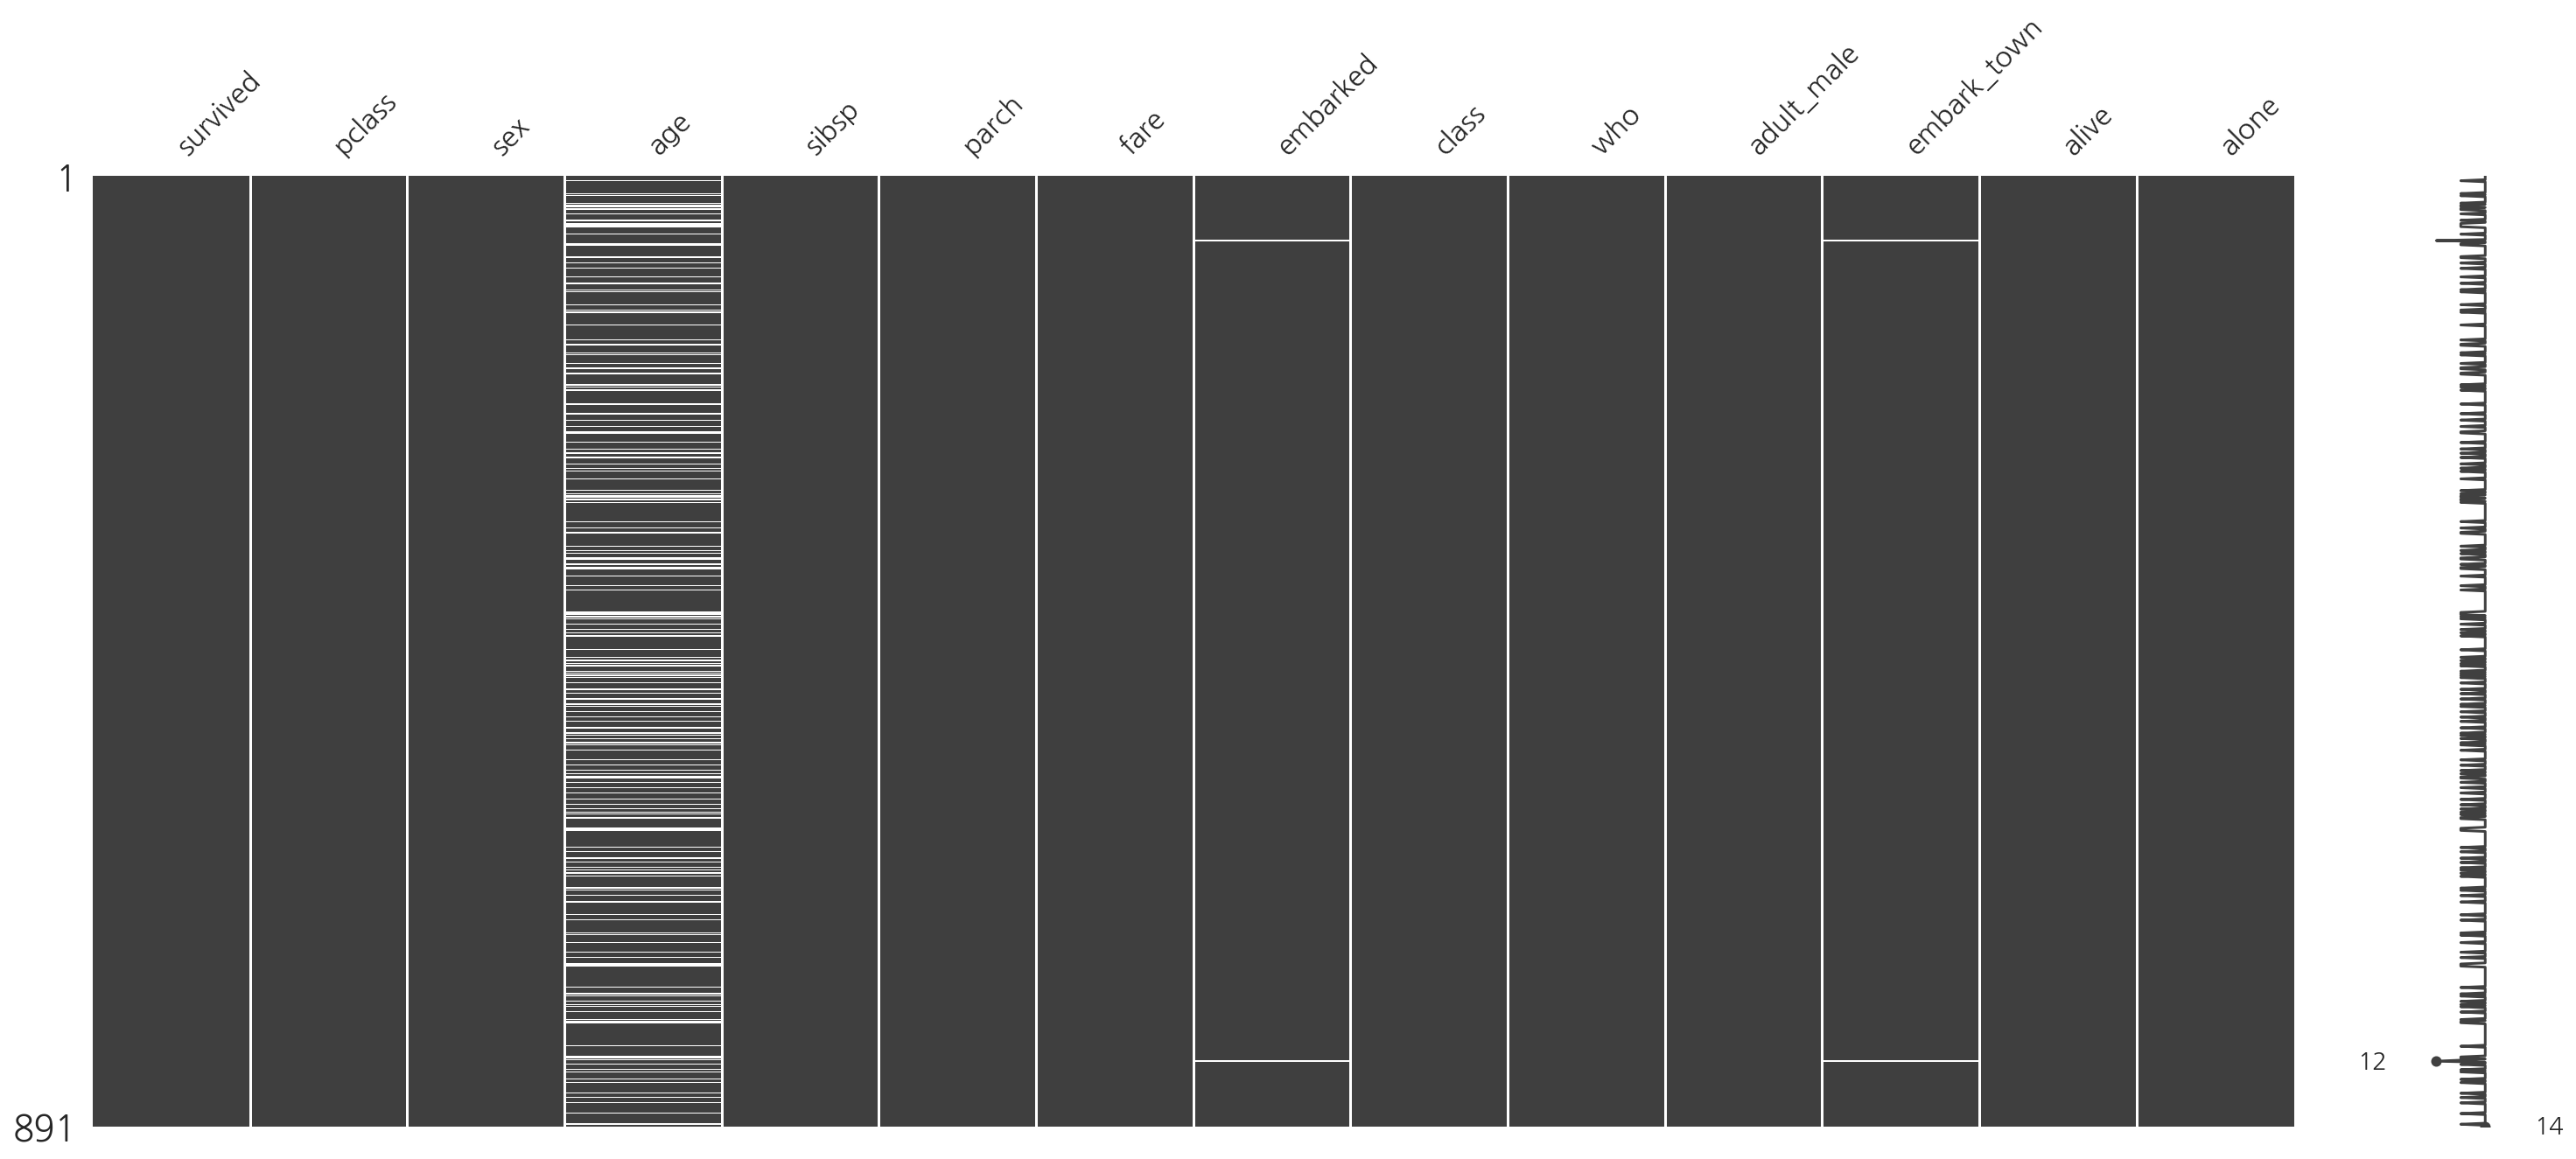

In [15]:
titanic = titanic.dropna(thresh=int(len(titanic) * 0.5), axis=1)
msno.matrix(titanic)
plt.show()

- titanic 데이터 각 열의 비결측값이 절반이상인 경우만 남겨 deck을 삭제하였다.

**결측값 대체**

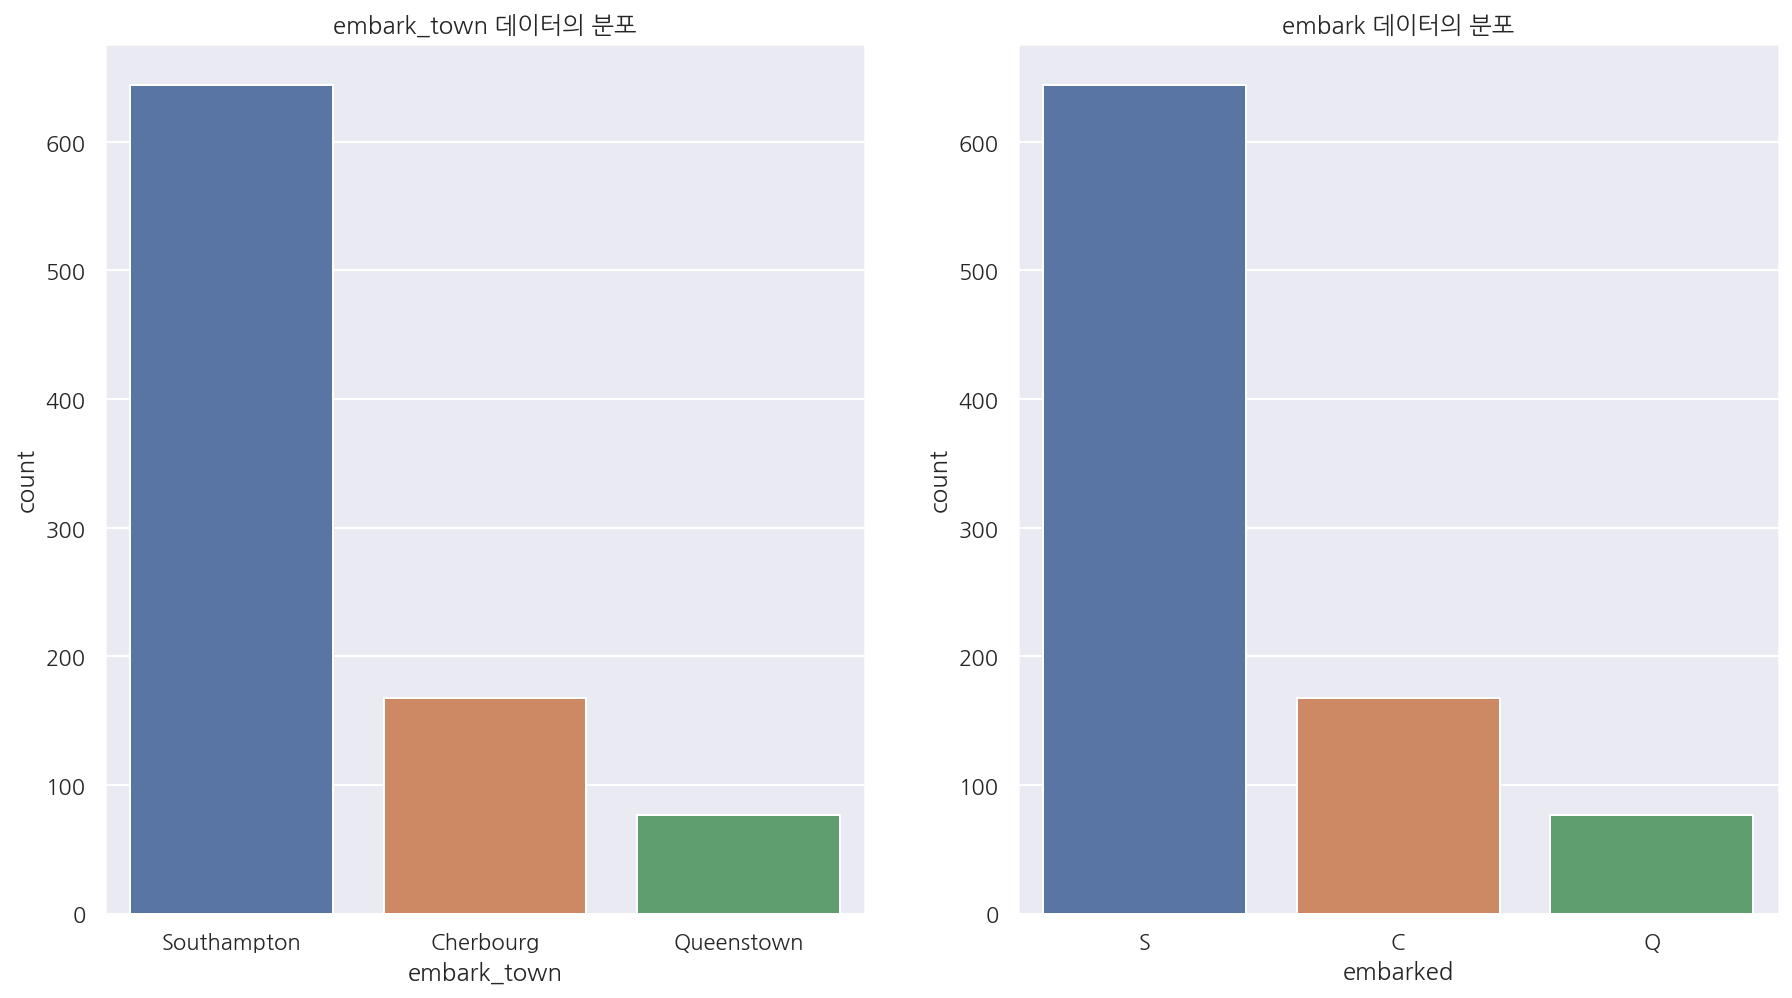

In [16]:
fig, axs = plt.subplots(1,2, figsize=(15,8))

sns.countplot(titanic.embark_town, ax = axs[0])
sns.countplot(titanic.embarked, ax = axs[1])

axs[0].set_title("embark_town 데이터의 분포")
axs[1].set_title("embark 데이터의 분포")

plt.show()

- embark_town, embark의 데이터 분포를 확인하였고 해당 데이터들의 최빈값으로 결측값을 대체 할 것이다.

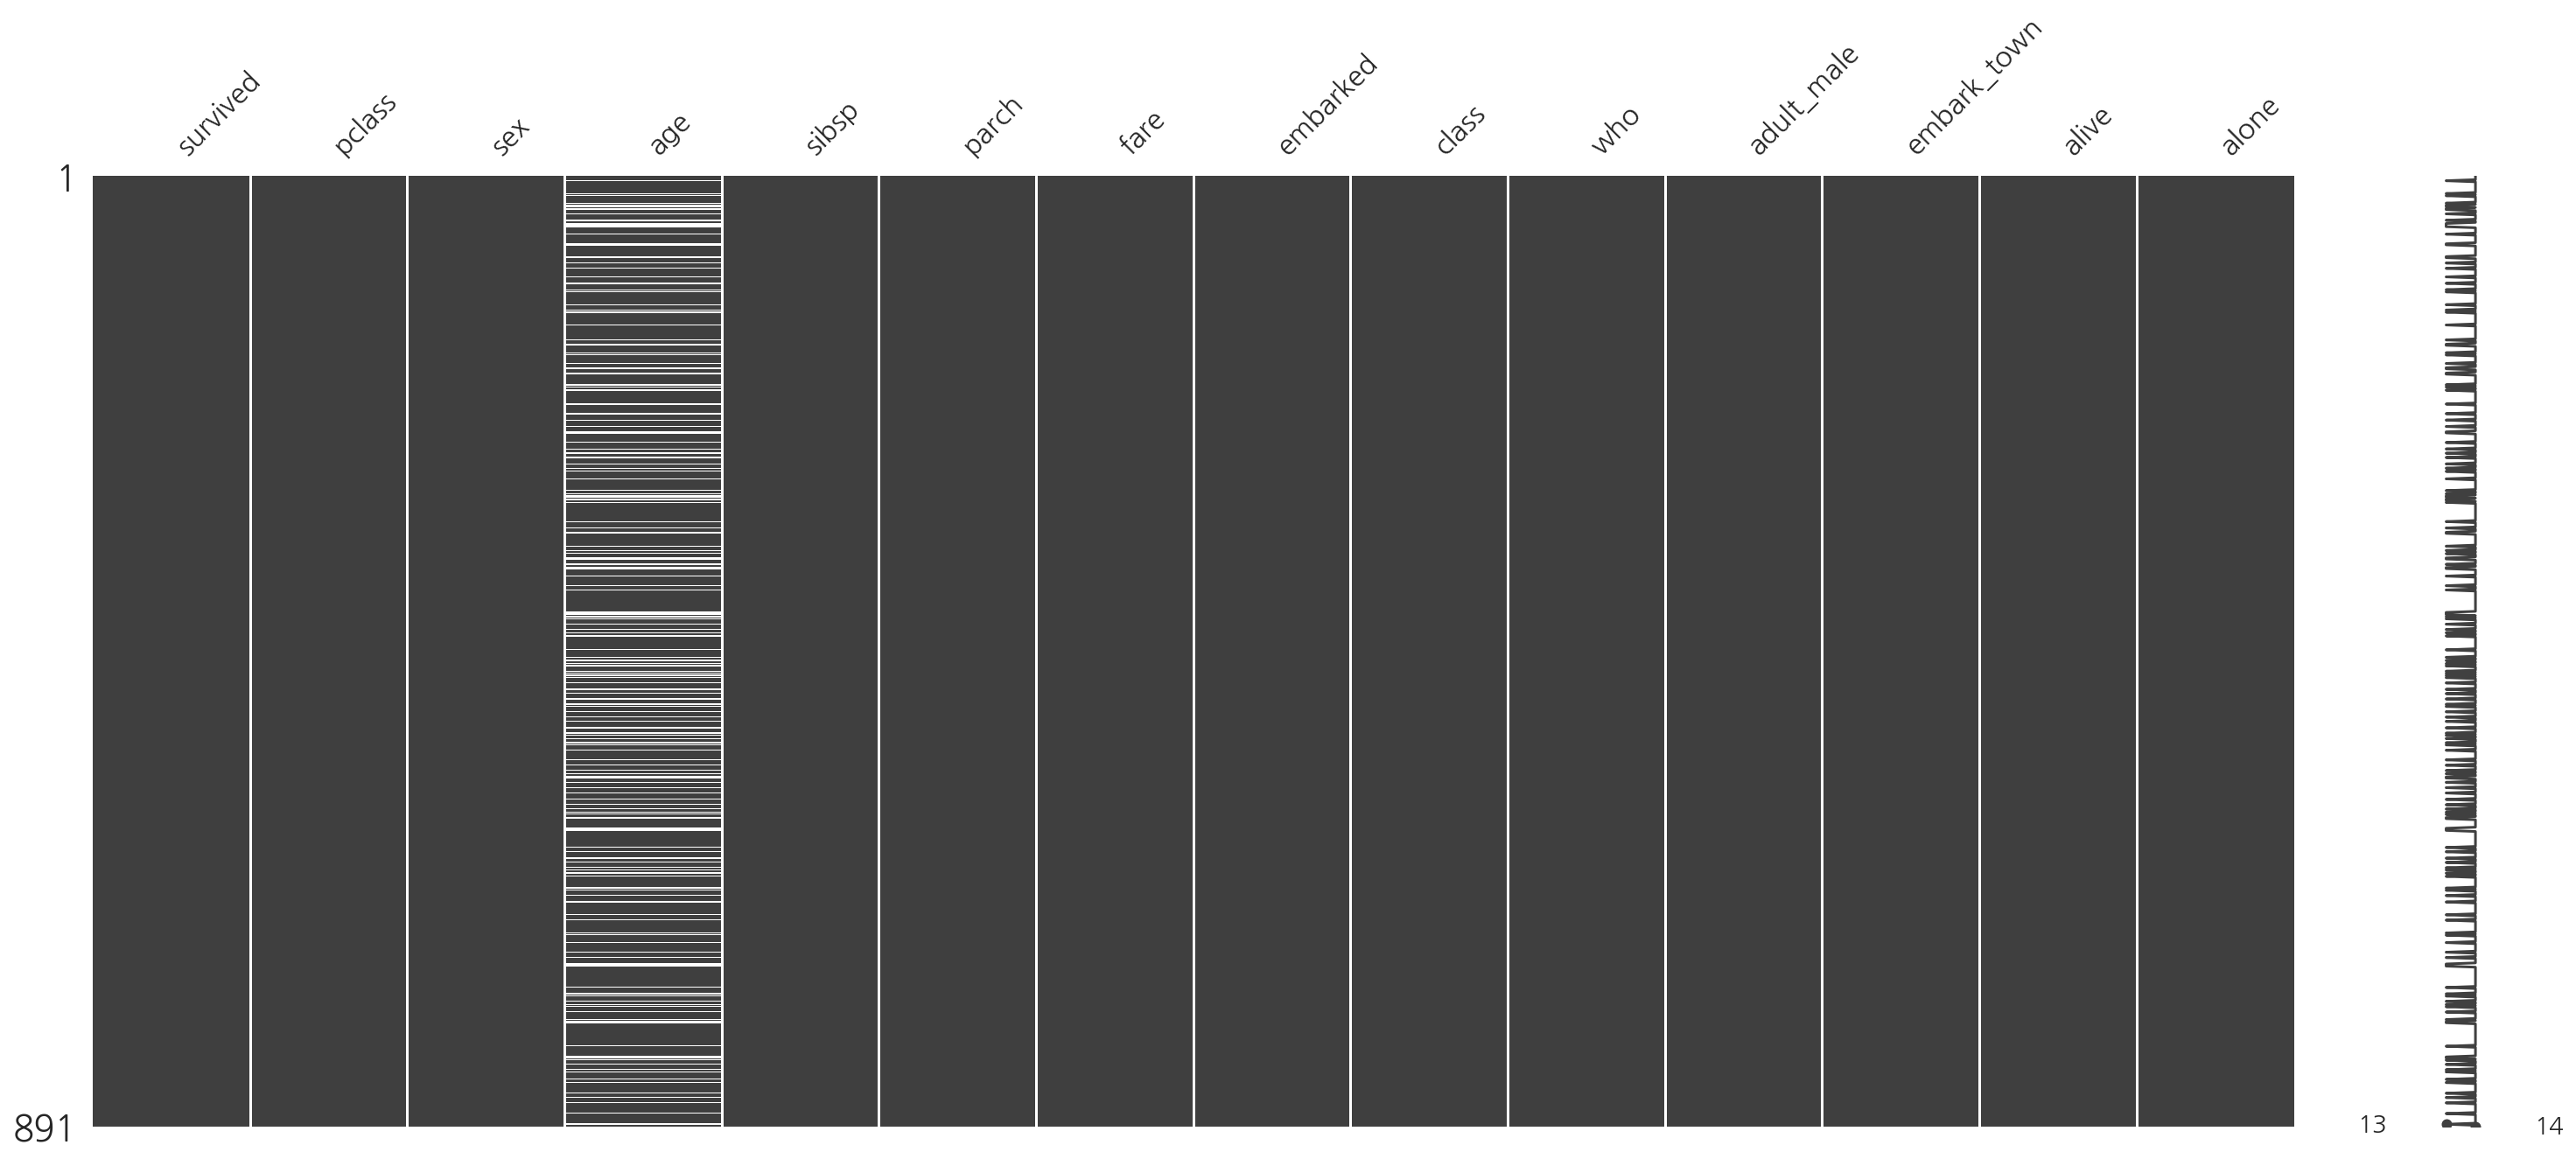

In [17]:
imp_mode = SimpleImputer(strategy="most_frequent")
titanic["embark_town"] = imp_mode.fit_transform(titanic[["embark_town"]])
titanic["embarked"] = imp_mode.fit_transform(titanic[["embarked"]])

msno.matrix(titanic)
plt.show()

- embark_town, embark의 결측값이 사라진 것을 확인 할 수 있다.

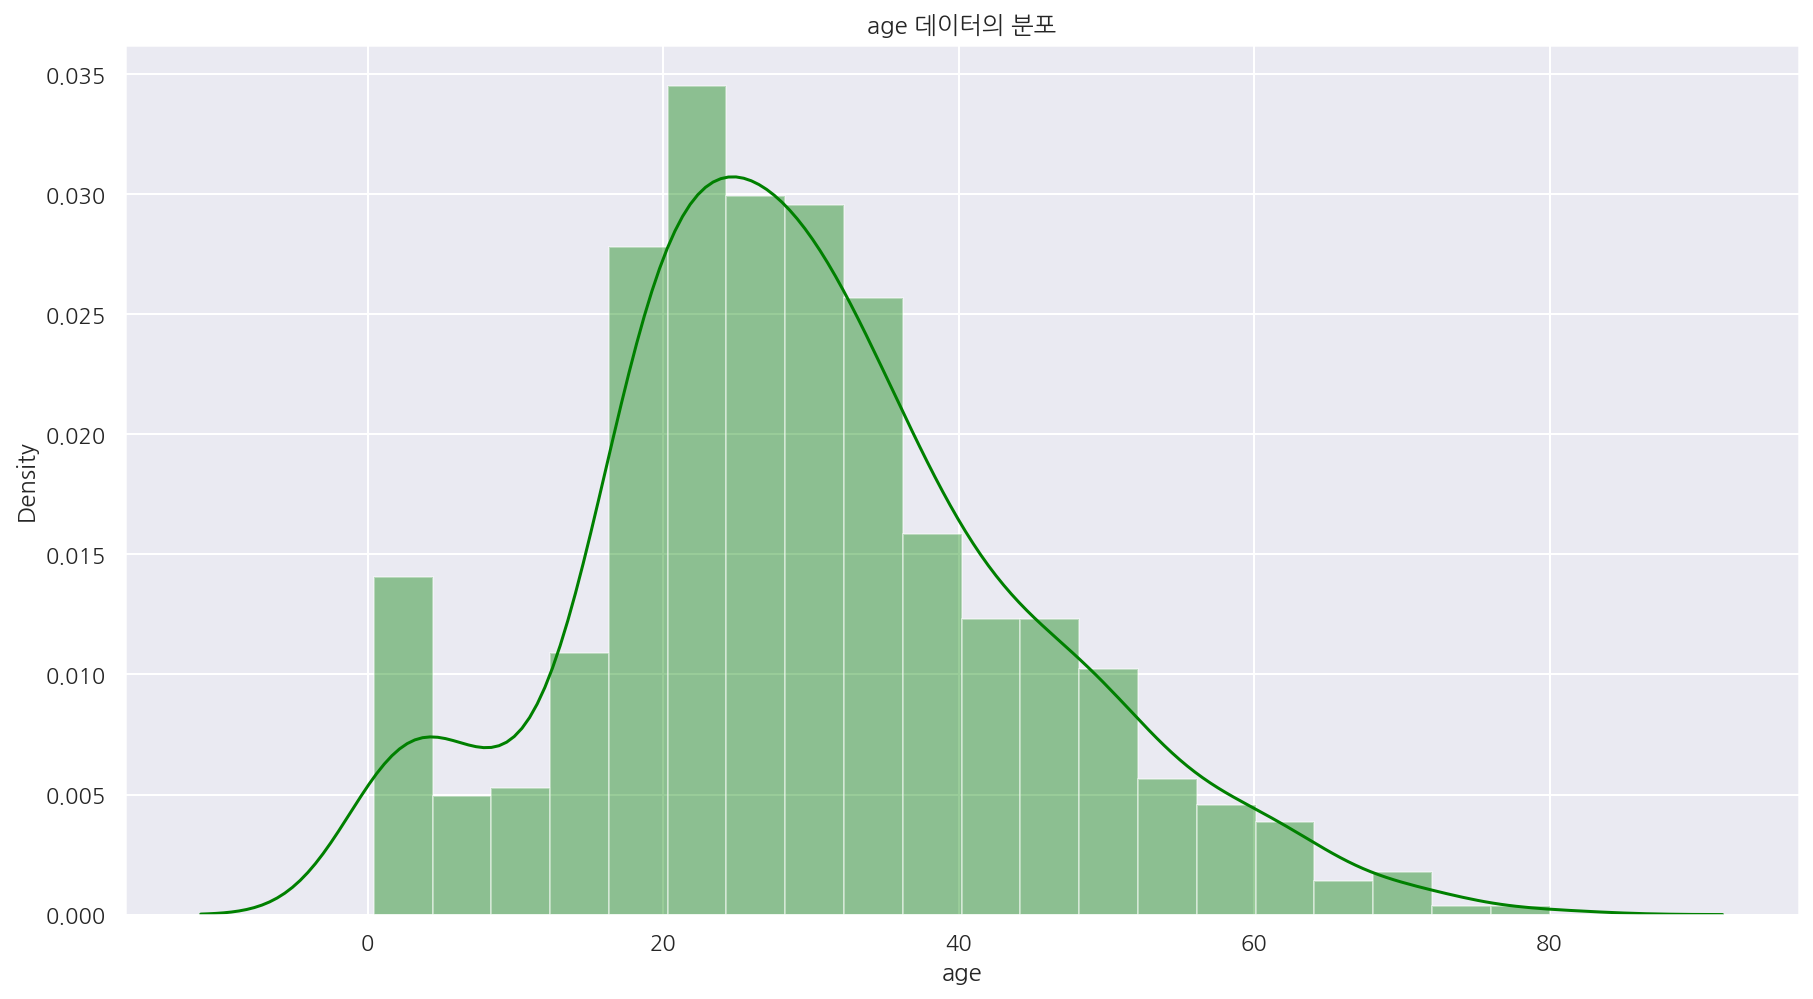

In [18]:
plt.figure(figsize=(15,8))

sns.distplot(titanic.age, kde=True, color="green")
plt.title("age 데이터의 분포")
plt.show()

- age의 분포를 확인하였을 때 비대칭 형태로 나옴을 확인 할 수 있다.


- 따라서 결측값을 중앙값으로 수정한다.

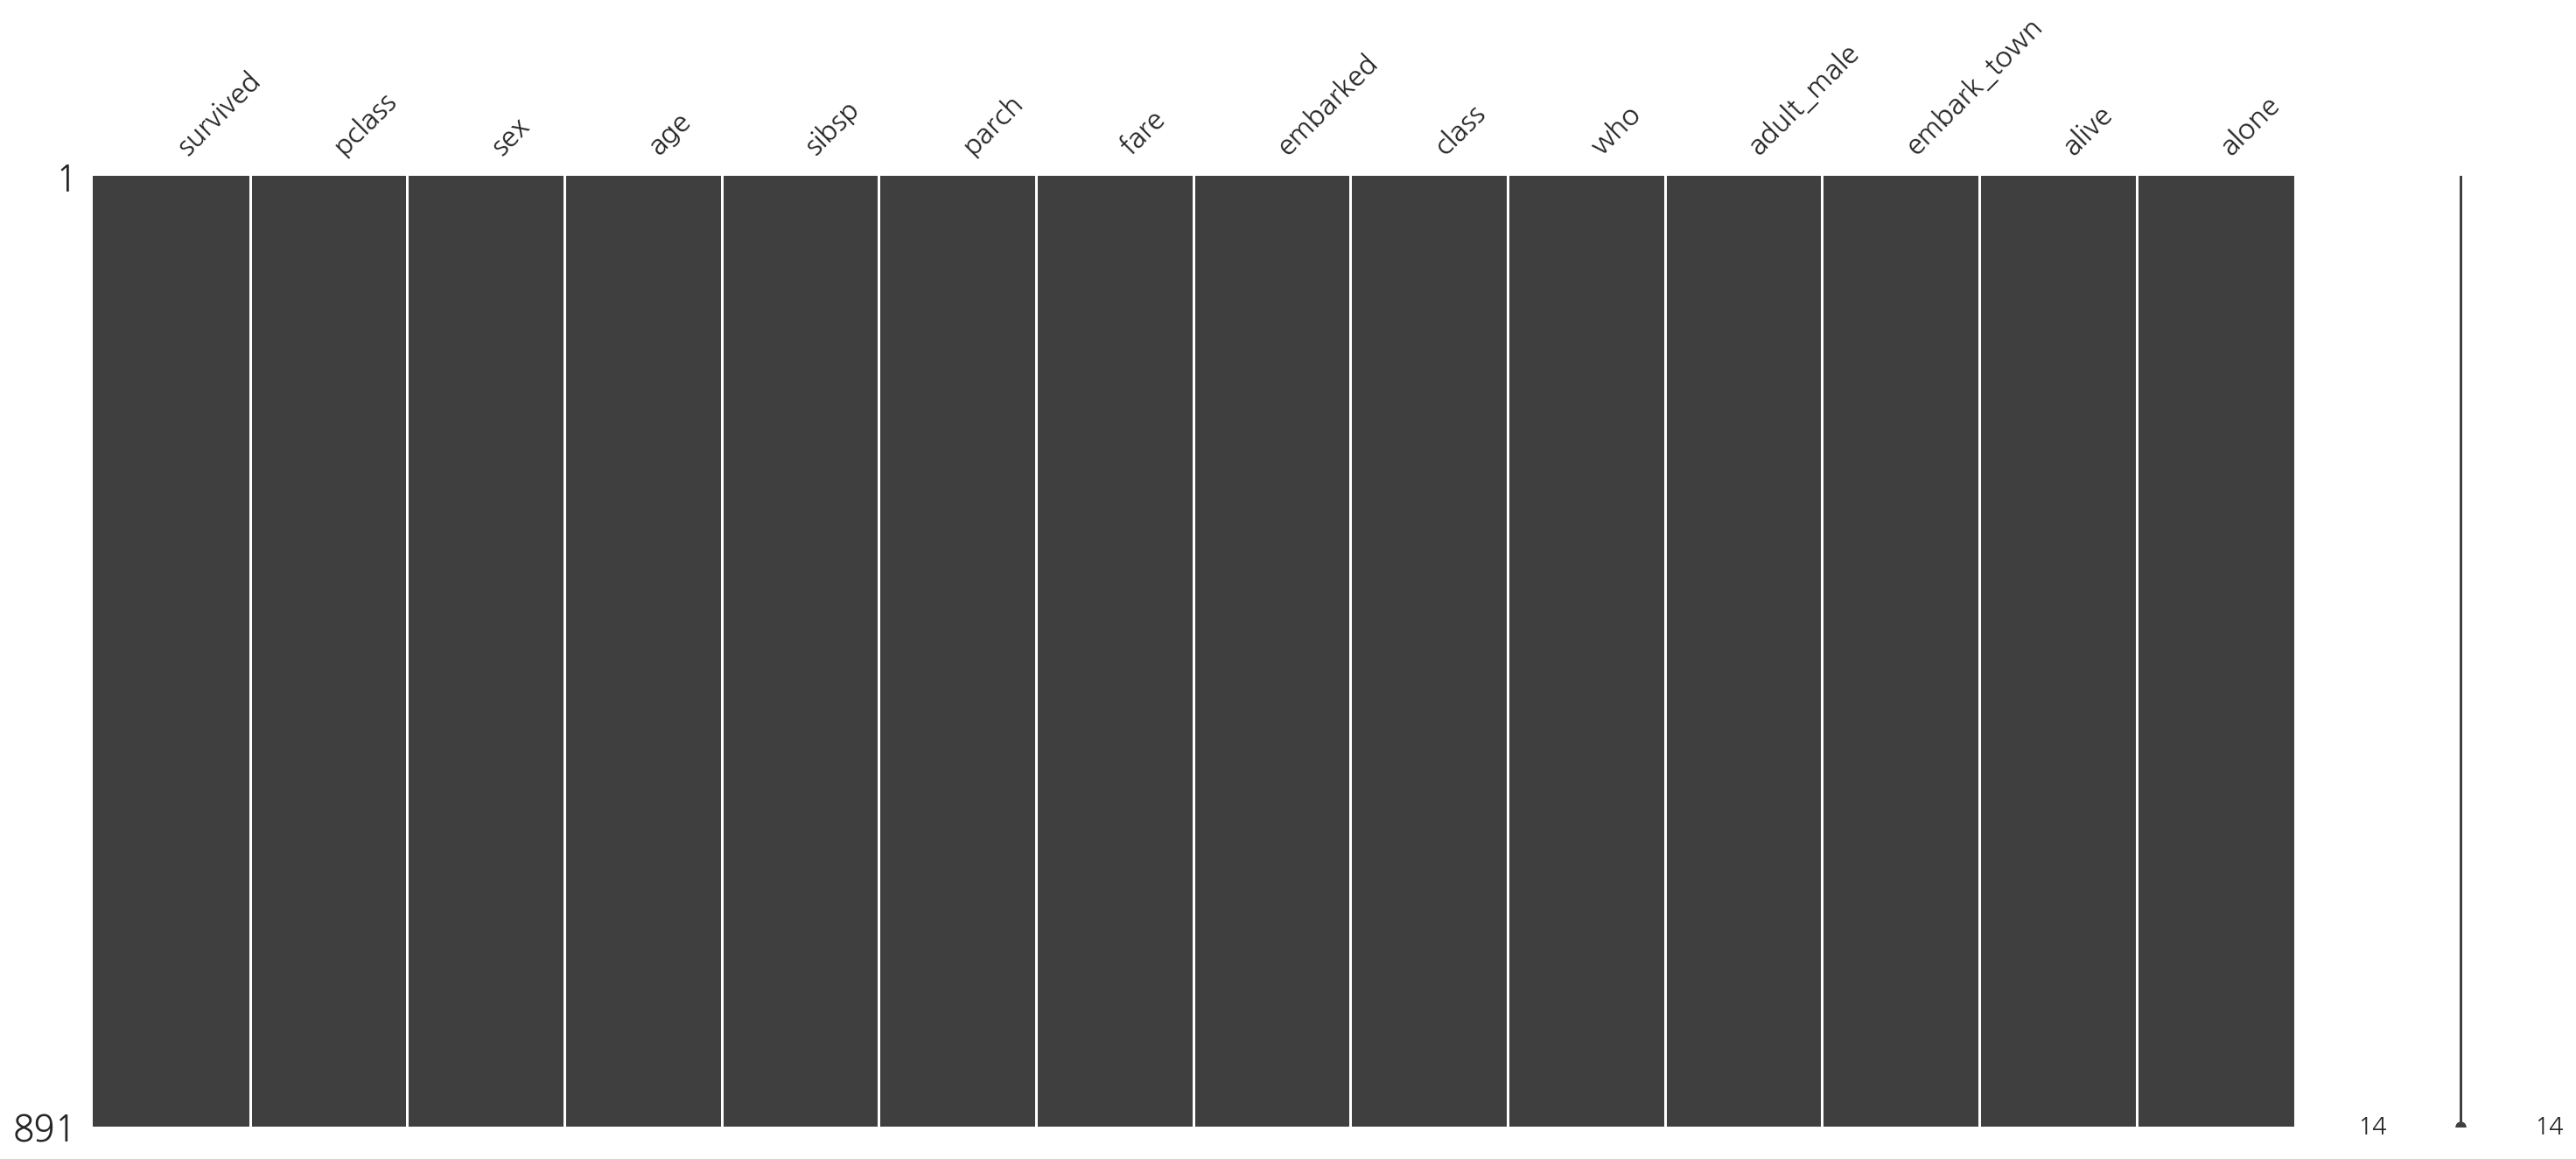

In [19]:
imp_median = SimpleImputer(strategy="median")
titanic["age"] = imp_median.fit_transform(titanic[["age"]])

msno.matrix(titanic)
plt.show()

- 모든 결측값이 사라진 것을 확인 할 수 있다.

# 2. 데이터 선택 및 스케일링

## 2.1 patsy 패키지

### 2.1.1 데이터 선택

In [20]:
df = pd.DataFrame(demo_data("x1", "x2", "x3", "x4", "x5"))
df

,x1,x2,x3,x4,x5
0,1.764052,-0.977278,0.144044,0.333674,-2.552990
1,0.400157,0.950088,1.454274,1.494079,0.653619
2,0.978738,-0.151357,0.761038,-0.205158,0.864436
3,2.240893,-0.103219,0.121675,0.313068,-0.742165
4,1.867558,0.410599,0.443863,-0.854096,2.269755


- `patsy` 의 `demo_data` 를 사용하여 임의의 실수 데이터를 생성가능하다.

In [21]:
dmatrix("x1 + x2 + x3 + 0", data = df)

DesignMatrix with shape (5, 3)
       x1        x2       x3
  1.76405  -0.97728  0.14404
  0.40016   0.95009  1.45427
  0.97874  -0.15136  0.76104
  2.24089  -0.10322  0.12168
  1.86756   0.41060  0.44386
  Terms:
    'x1' (column 0)
    'x2' (column 1)
    'x3' (column 2)

- `patsy` 의 `dmatrix(formula, data)` 를 이용하여 formula에서 지정한대로 data를 변환해서 출력할 수 있다.


- 전체 데이터에서 x1, x2, x3를 추출하였다.

In [22]:
dmatrix("x1 + x2 + x3", data = df)

DesignMatrix with shape (5, 4)
  Intercept       x1        x2       x3
          1  1.76405  -0.97728  0.14404
          1  0.40016   0.95009  1.45427
          1  0.97874  -0.15136  0.76104
          1  2.24089  -0.10322  0.12168
          1  1.86756   0.41060  0.44386
  Terms:
    'Intercept' (column 0)
    'x1' (column 1)
    'x2' (column 2)
    'x3' (column 3)

- +0 (혹은 -1) 옵션이 없으면 Intercept라는 상수열이 추가된다.

In [23]:
# numpy 함수
# dmatrix("x1 + np.log(np.abs(x2))", data = df)

# 사용자 정의 함수
def ten_times(x):
    return 10 * x

dmatrix("ten_times(x1)", data = df)

DesignMatrix with shape (5, 2)
  Intercept  ten_times(x1)
          1       17.64052
          1        4.00157
          1        9.78738
          1       22.40893
          1       18.67558
  Terms:
    'Intercept' (column 0)
    'ten_times(x1)' (column 1)

- `numpy` 함수 및 사용자 정의 함수 등도 사용가능하다.

In [24]:
# 상호작용항
# dmatrix("x1 + x2 + x1:x2 + 0", data = df)
dmatrix("x1 * x2 + 0", data = df)

DesignMatrix with shape (5, 3)
       x1        x2     x1:x2
  1.76405  -0.97728  -1.72397
  0.40016   0.95009   0.38018
  0.97874  -0.15136  -0.14814
  2.24089  -0.10322  -0.23130
  1.86756   0.41060   0.76682
  Terms:
    'x1' (column 0)
    'x2' (column 1)
    'x1:x2' (column 2)

- `:` 또는 `*`을 사용하여 두 변수의 곱으로 나타나는 상호작용항을 출력할 수 있다.

In [25]:
dmatrix("x1 + x2 + I(x1 + x2) + 0", data = df)

DesignMatrix with shape (5, 3)
       x1        x2  I(x1 + x2)
  1.76405  -0.97728     0.78677
  0.40016   0.95009     1.35025
  0.97874  -0.15136     0.82738
  2.24089  -0.10322     2.13767
  1.86756   0.41060     2.27816
  Terms:
    'x1' (column 0)
    'x2' (column 1)
    'I(x1 + x2)' (column 2)

- 곱을 제외한 변수의 연산은 `I()` 안에 기입하여 출력 가능하다.

### 2.1.2 데이터 스케일링

>선형회귀분석을 할 때는 조건수(condition number)의 영향때문에 데이터의 평균을 0으로 표준편차를 1로 만드는 스케일링(scaling) 작업을 하는 것이 분석 결과의 품질을 높일 수 있다.

In [26]:
dm = dmatrix("center(x1) + 0", data = df)
dm

DesignMatrix with shape (5, 1)
  center(x1)
     0.31377
    -1.05012
    -0.47154
     0.79061
     0.41728
  Terms:
    'center(x1)' (column 0)

- `center()` 를 이용하여 평균을 0으로 스케일링 하였다.


- 이는 `df.x1 - np.mean(df.x1)`와 같다.

In [27]:
dmatrix("standardize(x1) + 0", data = df)

DesignMatrix with shape (5, 1)
  standardize(x1)
          0.47060
         -1.57500
         -0.70723
          1.18578
          0.62584
  Terms:
    'standardize(x1)' (column 0)

- `standardize()` 를 이용하여 평균을 0, 표준편차를 1로 스케일링 하였다.


- 이는 `(df.x1 - np.mean(df.x1)) / np.std(df.x1)`와 같다.

In [28]:
dmatrix("scale(x1) + 0", data = df)

DesignMatrix with shape (5, 1)
  scale(x1)
    0.47060
   -1.57500
   -0.70723
    1.18578
    0.62584
  Terms:
    'scale(x1)' (column 0)

- `scale()` 은 `standardize()` 와 같은 결과이다.

## 2.2 sklearn.preprocessing 패키지

In [29]:
X = np.arange(7).reshape(-1, 1)
X

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6]])

In [30]:
scaler = StandardScaler()
scaler.fit_transform(X)

array([[-1.5],
       [-1. ],
       [-0.5],
       [ 0. ],
       [ 0.5],
       [ 1. ],
       [ 1.5]])

- `sklearn.preprocessing` 의 `StandardScaler` 를 이용하여 평균을 0, 표준편차를 1로 스케일링 하였다.

In [31]:
# Outlier 추가
X2 = np.vstack([X, [[1000]]])
X2

array([[   0],
       [   1],
       [   2],
       [   3],
       [   4],
       [   5],
       [   6],
       [1000]])

In [32]:
scaler = RobustScaler()
scaler.fit_transform(X2)

array([[-1.00000000e+00],
       [-7.14285714e-01],
       [-4.28571429e-01],
       [-1.42857143e-01],
       [ 1.42857143e-01],
       [ 4.28571429e-01],
       [ 7.14285714e-01],
       [ 2.84714286e+02]])

- `sklearn.preprocessing` 의 `RobustScaler` 를 이용하여 중앙값을 0, IQR을 1로 스케일링 하였다.


- 이상값이 있는 경우 `RobustScaler`를 사용한다.

In [33]:
poly = PolynomialFeatures(degree = 2, include_bias = True)
poly.fit_transform(X)

array([[ 1.,  0.,  0.],
       [ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.],
       [ 1.,  5., 25.],
       [ 1.,  6., 36.]])

- `sklearn.preprocessing` 의 `PolynomialFeatures` 를 이용하면 다항식을 만들 수 있다.

$$
x_1 \rightarrow 1, \ x_1, \ x_1^2, \ x_1^3, \ ...
$$


- `degree` 는 차수 `include_bias` 는 상수항 생성 여부이다.

In [34]:
X = np.arange(9).reshape(-1, 1) 
X

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8]])

In [35]:
def Square(X):
    x = X
    y = X**2
    X_new = np.hstack([x, y])
    return X_new

func_trans = FunctionTransformer(Square)
X2 = func_trans.fit_transform(X)
X2

array([[ 0,  0],
       [ 1,  1],
       [ 2,  4],
       [ 3,  9],
       [ 4, 16],
       [ 5, 25],
       [ 6, 36],
       [ 7, 49],
       [ 8, 64]])

- `sklearn.preprocessing` 의 `FunctionTransformer` 를 이용하면 함수식을 만들 수 있다.

$$
x_1 \rightarrow f_1(x), \ f_2(x), \ f_3(x), \ ...
$$


- 위의 경우 $X$와 $X^2$ 값을 출력하였다.

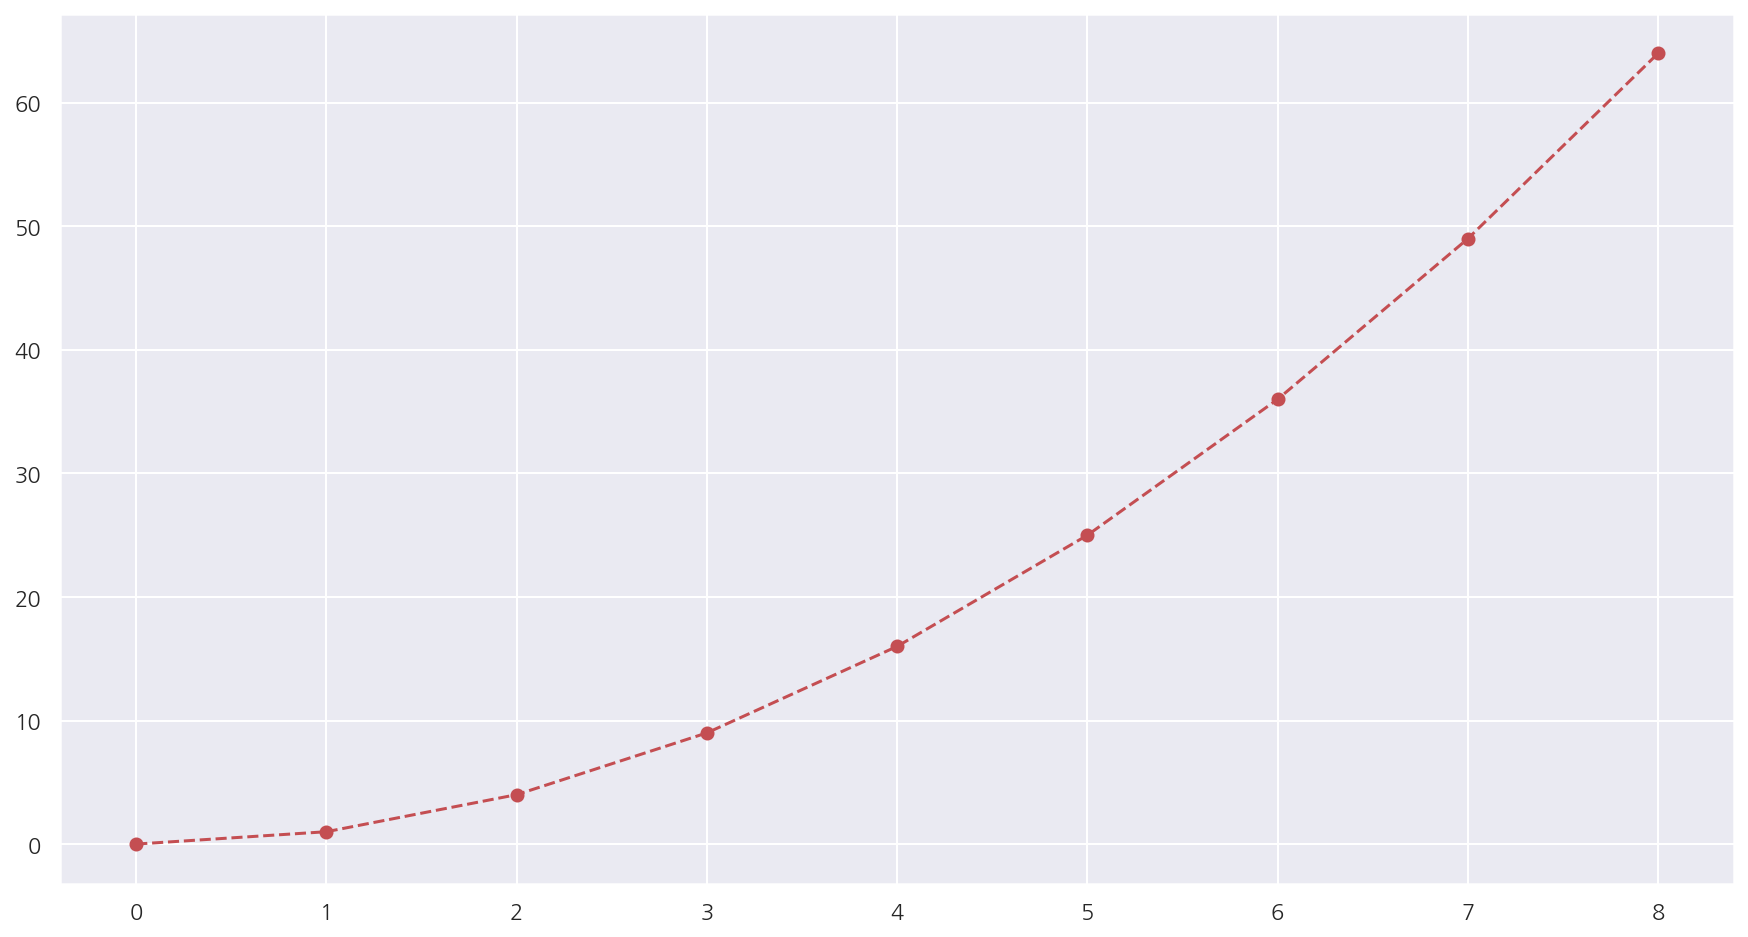

In [36]:
plt.figure(figsize=(15,8))
plt.plot(X2[:,0], X2[:,1], "ro--")

plt.show()

- 그림으로 잘 변환된 것을 확인 할 수 있다.

# 3. 범주형 데이터 처리

## 3.1 풀랭크(Full-Rank)

In [37]:
df1 = pd.DataFrame(["A", "B", "AB", "O"], columns=["x"])
df1

,x
0,A
1,B
2,AB
3,O


In [38]:
dmatrix("x + 0", data = df1)

DesignMatrix with shape (4, 4)
  x[A]  x[AB]  x[B]  x[O]
     1      0     0     0
     0      0     1     0
     0      1     0     0
     0      0     0     1
  Terms:
    'x' (columns 0:4)

- 혈액형 X가 A일 때 1,0,0,0
    
    혈액형 x가 B일 때 0,0,1,0 등으로 출력되는 것을 확인 할 수 있다.

In [39]:
df3 = pd.DataFrame([1, 2, 3, 4], columns=["x"])
df3

,x
0,1
1,2
2,3
3,4


In [40]:
dmatrix("C(x) + 0", data = df3)

DesignMatrix with shape (4, 4)
  C(x)[1]  C(x)[2]  C(x)[3]  C(x)[4]
        1        0        0        0
        0        1        0        0
        0        0        1        0
        0        0        0        1
  Terms:
    'C(x)' (columns 0:4)

- 정수로 된 범주형 데이터의 경우 `C()` 를 사용한다.

In [41]:
dm = dmatrix("C(x, levels=['A', 'B', 'AB', 'O']) + 0", data = df1)
dm

DesignMatrix with shape (4, 4)
  Columns:
    ["C(x, levels=['A', 'B', 'AB', 'O'])[A]",
     "C(x, levels=['A', 'B', 'AB', 'O'])[B]",
     "C(x, levels=['A', 'B', 'AB', 'O'])[AB]",
     "C(x, levels=['A', 'B', 'AB', 'O'])[O]"]
  Terms:
    "C(x, levels=['A', 'B', 'AB', 'O'])" (columns 0:4)
  (to view full data, use np.asarray(this_obj))

In [42]:
np.asarray(dm)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

- `C()` 안에 `levels` 를 사용하여 각 범주값이 대응하는 더미변수의 순서도 바꿀 수 있다.

## 3.2 축소랭크(reduce-rank)

In [43]:
dmatrix("x", data = df1)

DesignMatrix with shape (4, 4)
  Intercept  x[T.AB]  x[T.B]  x[T.O]
          1        0       0       0
          1        0       1       0
          1        1       0       0
          1        0       0       1
  Terms:
    'Intercept' (column 0)
    'x' (columns 1:4)

- 축소랭크 방식에선 특정한 하나의 범주값을 기준으로 하여 기준값에 대응하는 더미변수 값은 모두 1로서 Intercpet로 설정한다.

In [44]:
dmatrix("C(x, Treatment('B'))", data = df1)

DesignMatrix with shape (4, 4)
  Columns:
    ['Intercept',
     "C(x, Treatment('B'))[T.A]",
     "C(x, Treatment('B'))[T.AB]",
     "C(x, Treatment('B'))[T.O]"]
  Terms:
    'Intercept' (column 0), "C(x, Treatment('B'))" (columns 1:4)
  (to view full data, use np.asarray(this_obj))

- `C()` 안에 `Treatment()` 를 사용하여 기준이 대는 범주값을 바꿀 수 있다.

## 3.3 두 개의 범주형 변수

### 3.3.1 통합 축소형 방식

In [45]:
df4 = pd.DataFrame([["A", "X"], ["B", "X"], ["A", "Y"], ["B", "Y"]], columns=["x1", "x2"])
df4

,x1,x2
0,A,X
1,B,X
2,A,Y
3,B,Y


In [46]:
dmatrix("x1 + x2", data = df4)

DesignMatrix with shape (4, 3)
  Intercept  x1[T.B]  x2[T.Y]
          1        0        0
          1        1        0
          1        0        1
          1        1        1
  Terms:
    'Intercept' (column 0)
    'x1' (column 1)
    'x2' (column 2)

- x1과 x2가 각각 축소된 것을 확인 할 수 있다.

In [47]:
dmatrix("x1 + x2 + 0", data = df4)

DesignMatrix with shape (4, 3)
  x1[A]  x1[B]  x2[T.Y]
      1      0        0
      0      1        0
      1      0        1
      0      1        1
  Terms:
    'x1' (columns 0:2)
    'x2' (column 2)

- x2만 축소된 것을 확인 할 수 있다.

### 3.3.2 상호작용 방식

In [48]:
dmatrix("x1:x2 + 0", data = df4)

DesignMatrix with shape (4, 4)
  x1[A]:x2[X]  x1[B]:x2[X]  x1[A]:x2[Y]  x1[B]:x2[Y]
            1            0            0            0
            0            1            0            0
            0            0            1            0
            0            0            0            1
  Terms:
    'x1:x2' (columns 0:4)

- 두 범주형 변수의 경우의 수를 갖는 새로운 범주형 변수의 풀랭크 방식으로 결과를 출력한다.